# Developing a Book Recommendation System using CLIPS

## Introduction

In this Jupyter notebook, we will be using a book dataset scraped from Amazon to build a recommendation system. The recommendation system uses an expert system at its core, written in CLIPS through the clipspy interface. The recommendation system will accept book titles as inputs and will infer the common category from the books using rules and facts. The resulting category will be used to suggest book titles for the user.

The dataset for this analysis can be retrieved from: https://github.com/luminati-io/Amazon-popular-books-dataset

## Data Analysis

### Data Cleaning

A number of Python packages will be used in the analysis, including:
- Pandas, Numpy and Matplotlib for data analysis and visualization
- Clips (clipspy) for building the expert system

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# import re

import clips
from clips import Environment,LoggingRouter
import logging

Using pandas, we can load the dataset from a CSV file directly to a dataframe.

In [2]:
df = pd.read_csv("./data/Amazon_popular_books_dataset.csv")

In [3]:
df.head()

,asin,ISBN10,answered_questions,availability,brand,currency,date_first_available,delivery,department,description,...,upc,url,video,video_count,categories,best_sellers_rank,buybox_seller,image,number_of_sellers,colors
0,0007350813,0007350813,0,In Stock.,Emily Brontë,USD,NaN,"[""FREE delivery Tuesday, December 28 if you sp...",NaN,NaN,...,NaN,https://www.amazon.com/dp/0007350813,NaN,0,"[""Books"",""Literature & Fiction"",""Genre Fiction""]","[{""category"":""Books / Literature & Fiction / H...",NaN,NaN,NaN,NaN
1,0007513763,9780007513765,0,In Stock.,Drew Daywalt,USD,NaN,"[""FREE delivery Tuesday, December 28 if you sp...",NaN,NaN,...,NaN,https://www.amazon.com/dp/0007513763,NaN,0,"[""Books"",""Children's Books"",""Literature & Fict...","[{""category"":""Books / Children's Books / Liter...",VMG Books & Media,NaN,NaN,NaN
2,0008183988,0008183988,0,NaN,Bernard Cornwell,USD,NaN,"[""FREE delivery January 4 - 10 if you spend $2...",NaN,NaN,...,NaN,https://www.amazon.com/dp/0008183988,NaN,0,"[""Books"",""Literature & Fiction"",""Genre Fiction""]","[{""category"":""Books / Literature & Fiction / H...",Reuseaworld,NaN,NaN,NaN
3,0008305838,0008305838,0,In Stock.,David Walliams,USD,NaN,"[""FREE delivery Tuesday, December 28 if you sp...",NaN,NaN,...,NaN,https://www.amazon.com/dp/0008305838,NaN,0,"[""Books"",""Children's Books"",""Literature & Fict...","[{""category"":""Books / Children's Books / Liter...",Bahamut Media,NaN,NaN,NaN
4,0008375526,0008375526,0,In Stock.,Caroline Hirons,USD,NaN,"[""FREE delivery Tuesday, December 28"",""Or fast...",NaN,NaN,...,NaN,https://www.amazon.com/dp/0008375526,NaN,0,"[""Books"",""Crafts, Hobbies & Home"",""Home Improv...","[{""category"":""Books / Health, Fitness & Dietin...",KathrynAshleyGallery,NaN,NaN,NaN


Having a look at the top-most rows of the dataset, a number of observations can be made:

- The author is described in the 'brand' column
- A book may belong to several categories
- All the books seem to belong to the 'Books' category which is redundant

Looking at the size of the dataset, there are 2269 rows and 40 columns for each row. 


In [4]:
df.shape

(2269, 40)

In [5]:
df.columns

Index(['asin', 'ISBN10', 'answered_questions', 'availability', 'brand',
       'currency', 'date_first_available', 'delivery', 'department',
       'description', 'discount', 'domain', 'features', 'final_price',
       'format', 'image_url', 'images_count', 'initial_price', 'item_weight',
       'manufacturer', 'model_number', 'plus_content', 'product_dimensions',
       'rating', 'reviews_count', 'root_bs_rank', 'seller_id', 'seller_name',
       'timestamp', 'title', 'upc', 'url', 'video', 'video_count',
       'categories', 'best_sellers_rank', 'buybox_seller', 'image',
       'number_of_sellers', 'colors'],
      dtype='object')

For the sake of this analysis, the majority of the columns are not useful e.g. seller_name, colors, images_count etc. Therefore, a subset of the dataset will be considered for further analysis. 
The columns to be considered are:
- asin
- title
- brand
- rating
- categories
- reviews_count

In [6]:
df_books = df[['asin','title','brand','rating','categories', 'reviews_count']].copy()

In [7]:
df_books.head()

,asin,title,brand,rating,categories,reviews_count
0,0007350813,Wuthering Heights (Collins Classics),Emily Brontë,4.6 out of 5 stars,"[""Books"",""Literature & Fiction"",""Genre Fiction""]",13451
1,0007513763,THE DAYS THE CRAYONS QUIT,Drew Daywalt,4.8 out of 5 stars,"[""Books"",""Children's Books"",""Literature & Fict...",16628
2,0008183988,War Lord: Book 13 (The Last Kingdom Series),Bernard Cornwell,4.8 out of 5 stars,"[""Books"",""Literature & Fiction"",""Genre Fiction""]",11275
3,0008305838,Code Name Bananas: The hilarious and epic new ...,David Walliams,4.8 out of 5 stars,"[""Books"",""Children's Books"",""Literature & Fict...",15520
4,0008375526,Skincare: The award-winning ultimate no-nonsen...,Caroline Hirons,4.8 out of 5 stars,"[""Books"",""Crafts, Hobbies & Home"",""Home Improv...",10884


From the dataset overview, the 'brand' column refers to the author and will be renamed to 'author':

In [8]:
df_books.rename({"brand":"author"}, axis=1, inplace=True)

In [9]:
df_books.dtypes

asin             object
title            object
author           object
rating           object
categories       object
reviews_count     int64
dtype: object

Looking at the columns and their datatypes, the following observations were noted:

- The 'categories' column is a string representation of a list
- The reviews_count is an integer
- The rest of the columns are strings

For clarity and sorting later on, it would be beneficial to convert the rating to the float notation.

In [10]:
# 1. Convert the string to a set of columns by splitting the string on the spaces
# 2. Taking the column index 0 to get the first column i.e. the rating out of 5
# 3. Converting the rating to the float notation
df_books['rating'] = df_books['rating'].str.split(' ', expand=True)[0].astype(float) 

In [11]:
df_books['rating']

0       4.6
1       4.8
2       4.8
3       4.8
4       4.8
       ... 
2264    4.2
2265    4.8
2266    4.7
2267    4.4
2268    4.8
Name: rating, Length: 2269, dtype: float64

Similarly, in order to manipulate and analyse the categories, we can convert the string representation of a list into an actual list.

In [12]:
df_books['categories'] = df_books['categories'].apply(eval) # convert string to list

In [13]:
df_books['categories']

0            [Books, Literature & Fiction, Genre Fiction]
1         [Books, Children's Books, Literature & Fiction]
2            [Books, Literature & Fiction, Genre Fiction]
3         [Books, Children's Books, Literature & Fiction]
4       [Books, Crafts, Hobbies & Home, Home Improveme...
                              ...                        
2264    [Books, Mystery, Thriller & Suspense, Thriller...
2265    [Books, Health, Fitness & Dieting, Women's Hea...
2266    [Books, Crafts, Hobbies & Home, Home Improveme...
2267    [Books, Mystery, Thriller & Suspense, Thriller...
2268    [Books, Arts & Photography, Music, Musical Gen...
Name: categories, Length: 2269, dtype: object

As mentioned before, the 'Books' category seems to be present in every row as the first category. This would cause the recommender system to pick up 'Book' as the most common category in every situation. We can create a function to remove the 'Books' category and apply it to the whole dataframe by using the 'apply' function.

In [14]:
def remove_books(categories): 
    if "Books" in categories:
        categories.remove("Books")
    return categories

In [15]:
df_books['categories'] = df_books['categories'].apply(remove_books) # remove books from categories

In [16]:
df_books[['title','categories']]

,title,categories
0,Wuthering Heights (Collins Classics),"[Literature & Fiction, Genre Fiction]"
1,THE DAYS THE CRAYONS QUIT,"[Children's Books, Literature & Fiction]"
2,War Lord: Book 13 (The Last Kingdom Series),"[Literature & Fiction, Genre Fiction]"
3,Code Name Bananas: The hilarious and epic new ...,"[Children's Books, Literature & Fiction]"
4,Skincare: The award-winning ultimate no-nonsen...,"[Crafts, Hobbies & Home, Home Improvement & De..."
...,...,...
2264,Unspeakable Things,"[Mystery, Thriller & Suspense, Thrillers & Sus..."
2265,What to Expect When You’re Expecting,"[Health, Fitness & Dieting, Women's Health, Pr..."
2266,The Home Edit: A Guide to Organizing and Reali...,"[Crafts, Hobbies & Home, Home Improvement & De..."
2267,The Family Upstairs: A Novel,"[Mystery, Thriller & Suspense, Thrillers & Sus..."


The next step is to check for any duplicates in the dataset. The query below identifies the rows with a duplicate title. 

In [17]:
df_books[df_books.duplicated(subset='title', keep=False)].sort_values(by='title')

,asin,title,author,rating,categories,reviews_count
269,0345816021,12 Rules for Life: An Antidote to Chaos,Jordan B. Peterson,4.8,"[Health, Fitness & Dieting, Psychology & Couns...",43801
101,0141988517,12 Rules for Life: An Antidote to Chaos,Jordan B. Peterson,4.8,"[Business & Money, Job Hunting & Careers]",43801
2198,B0797Y87JC,12 Rules for Life: An Antidote to Chaos,"Jordan B. Peterson (Author, Narrator), Norman ...",4.8,"[Health, Fitness & Dieting, Psychology & Couns...",43801
1760,B09C6GMVLH,1984,George Orwell,4.7,"[Politics & Social Sciences, Social Sciences]",55581
1749,B0968319S1,1984,"George Orwell (Author), Benjamin May (Narrator...",4.7,"[Science Fiction & Fantasy, Science Fiction, D...",55582
...,...,...,...,...,...,...
624,0765365286,Words of Radiance: Book Two of the Stormlight ...,Brandon Sanderson,4.9,"[Literature & Fiction, Action & Adventure]",18070
430,0553386883,Written in My Own Heart's Blood: A Novel (Outl...,Diana Gabaldon,4.8,"[Science Fiction & Fantasy, Fantasy]",23889
749,110188424X,Written in My Own Heart's Blood: A Novel (Outl...,Diana Gabaldon,4.8,"[Science Fiction & Fantasy, Fantasy]",23889
1981,B00M284NY2,"Zero to One: Notes on Startups, or How to Buil...","Peter Thiel (Author), Blake Masters (Author, N...",4.6,"[Business & Money, Job Hunting & Careers, Guides]",10690


In [18]:
df_books[df_books.duplicated(subset='reviews_count', keep=False)].sort_values(by='reviews_count')

,asin,title,author,rating,categories,reviews_count
1328,1912714949,The Secret Garden (Chiltern Classic),Frances Hodgson Burnett,4.7,"[Crafts, Hobbies & Home, Antiques & Collectibles]",10041
50,0062981951,The Secret Garden,Frances Hodgson Burnett,4.7,"[Children's Books, Literature & Fiction]",10041
85,006440188X,The Secret Garden (HarperClassics),Frances Hodgson Burnett,4.7,"[Children's Books, Literature & Fiction]",10041
1001,1501111116,Grit: The Power of Passion and Perseverance,Angela Duckworth,4.6,"[Health, Fitness & Dieting, Psychology & Couns...",10042
998,1501111108,Grit: The Power of Passion and Perseverance,Angela Duckworth,4.6,"[Health, Fitness & Dieting, Psychology & Couns...",10042
...,...,...,...,...,...,...
528,0525559477,The Midnight Library: A Novel,Matt Haig,4.3,"[Science Fiction & Fantasy, Science Fiction]",122000
1578,B085S8BSYS,The Midnight Library: A Novel,"Matt Haig (Author), Carey Mulligan (Narrator),...",4.3,"[Science Fiction & Fantasy, Science Fiction, T...",122000
640,0735219095,Where the Crawdads Sing,Delia Owens,4.8,"[Literature & Fiction, Genre Fiction]",196572
461,0593105419,Where the Crawdads Sing,Delia Owens,4.8,"[Literature & Fiction, Genre Fiction]",196572


From the preview above, the duplicate titles in the dataset share the following characteristics:
- Identical review count and rating
- Author may be different
- Different entries belong to different categories

Looking at '1984' by George Orwell as an example:

In [19]:
for index,row in df_books[df_books.title == "1984"].iterrows():
    print(f"Index [{index}] has categories {row['categories']}")

Index [416] has categories ['Literature & Fiction', 'Genre Fiction']
Index [418] has categories ['Literature & Fiction', 'Genre Fiction']
Index [786] has categories ['Literature & Fiction', 'Genre Fiction']
Index [1694] has categories ['Literature & Fiction', 'Genre Fiction', 'Political']
Index [1749] has categories ['Science Fiction & Fantasy', 'Science Fiction', 'Dystopian']
Index [1760] has categories ['Politics & Social Sciences', 'Social Sciences']


To consolidate all the duplicate entries, we can take the following approach:

1. Duplicates (based on titles)
    - Loop over the sorted duplicate titles in the dataset
    - Maintain a list of all the categories for a specific title
    - Maintain a list of all the indices for a specific title
    - Once a different title is encountered:
        - Get the first index for that title
        - Assign the unique categories to that title
        - Drop the rest of the indices
    - Repeat until the dataframe is exhausted
    
2. Duplicates (based on reviews and rating)
    - Loop over the dataset sorted by rating and review count
    - Assume that a different rating/review combination is a new book
    - Maintain a list of all the categories for a specific book
    - Maintain a list of all the indices for a specific book
    - Once a different book is encountered:
        - Get the first index for that title
        - Assign the unique categories to that title
        - Drop the rest of the indices
    - Repeat until the dataframe is exhausted

In [20]:
# Duplicate Titles
first_loop = True
curr_categories = []
for index,book in df_books[df_books.duplicated(subset='title', keep=False)].sort_values(by='title').iterrows():
    if first_loop:
        # the first loop
        # initialize the lists
        first_loop = False
        prev_book = book # set the current book as the new book
        curr_categories = book['categories']
        curr_indices = [index]
    elif prev_book['title'] != book['title']:
        # a new book title
        df_books.drop(curr_indices[1:], axis=0, inplace=True) # drop the extra rows  
        df_books.at[curr_indices[0], 'categories'] = list(set(curr_categories)) # assign the unique categories  
        prev_book = book # set the current book as the new book
        curr_categories = book['categories']
        curr_indices = [index]
    else:
        # a previously encountered title
        curr_categories.extend(book['categories']) # add the current entry's categories
        curr_indices.append(index) # add the current entry's index
else:
    # the last book in the loop
    df_books.drop(curr_indices[1:], axis=0, inplace=True)
    df_books.at[curr_indices[0], 'categories'] = list(set(curr_categories))
    

    

In [21]:
# Duplicate Ratings/Reviews
first_loop = True
curr_categories = []
for index,book in df_books[df_books.duplicated(subset='reviews_count', keep=False)].sort_values(by=['reviews_count', 'rating']).iterrows():
    if first_loop:
        # the first loop
        # initialize the lists
        first_loop = False
        prev_book = book # set the current book as the new book
        curr_categories = book['categories']
        curr_indices = [index]
    elif prev_book['reviews_count'] != book['reviews_count'] or prev_book['rating'] != book['rating']:
        # a new book (based rating and review count)
        df_books.drop(curr_indices[1:], axis=0, inplace=True) # drop the extra rows  
        df_books.at[curr_indices[0], 'categories'] = list(set(curr_categories)) # assign the unique categories  
        prev_book = book # set the current book as the new book
        curr_categories = book['categories']
        curr_indices = [index]
    else:
        # a previously encountered book (based rating and review count)
        curr_categories.extend(book['categories']) # add the current entry's categories
        curr_indices.append(index) # add the current entry's index
else:
    # the last book in the loop
    df_books.drop(curr_indices[1:], axis=0, inplace=True)
    df_books.at[curr_indices[0], 'categories'] = list(set(curr_categories))

Checking '1984' to confirm that 1 row remains with all the categories:

In [22]:
for index,row in df_books[df_books.title == "1984"].iterrows():
    print(f"Index [{index}] has categories {row['categories']}")

Index [1760] has categories ['Genre Fiction', 'Dystopian', 'Science Fiction & Fantasy', 'Social Sciences', 'Science Fiction', 'Politics & Social Sciences', 'Political', 'Literature & Fiction']


In [23]:
df_books.shape

(1059, 6)

The removal of duplicates reduced the overall dataset size to 1062 rows. The last check in the data cleaning step is for any null values:

In [24]:
df_books.isnull().sum()

asin             0
title            0
author           1
rating           0
categories       0
reviews_count    0
dtype: int64

In [25]:
df_books[df_books['author'].isnull()]

,asin,title,author,rating,categories,reviews_count
594,0762459816,The Screaming Goat (Book & Figure),NaN,4.7,"[Humor & Entertainment, Humor]",22185


After checking the book above manually on Amazon, it seems that there is no specific author but it is listed under the publisher. To avoid errors, we will manually set the author to the publisher i.e. 'Running Press'. Since it is the only null field, the fillna() function can be used.

In [26]:
df_books.fillna("Running Press", inplace=True)

In [27]:
df_books.iloc[594]

asin                                                    1508239789
title                         All the Light We Cannot See: A Novel
author                                               Anthony Doerr
rating                                                         4.6
categories       [Genre Fiction, Military, Literature & Fiction...
reviews_count                                                53837
Name: 1053, dtype: object

In [28]:
df_books[df_books['author'].isnull()]

,asin,title,author,rating,categories,reviews_count


### Data Analysis

To analyse the counts of each occurence within the dataset, we define a helper function which returns a sorted counter. The function can also handle columns which are lists such as the 'categories' column.

In [29]:
def get_count_per_column(df, counted_column, is_list = False):
    all_occurrences = []
    for book_column in df[counted_column]: # append all the occurrences to a single list
        if is_list:
            all_occurrences.extend(book_column) 
        else:
            all_occurrences.append(book_column)
    counts = {}
    for occurrence in all_occurrences:
        counts[occurrence] = counts.get(occurrence,0) + 1  # increment the counter for each occurrence
    sorted_counts = sorted(counts.items(), key=lambda x: x[1], reverse=True)  # sort according to count, highest to lowest
    return sorted_counts

In [30]:
author_counts = get_count_per_column(df_books, 'author')
author_counts[:6] # top 5 occurring authors

[('Sarah J. Maas', 13),
 ('John Grisham', 12),
 ('Dav Pilkey', 11),
 ('Stephen King', 10),
 ('Julia Quinn', 8),
 ('Dr. Seuss', 8)]

In [31]:
len(author_counts) # distinct authors

776

In [32]:
category_counts = get_count_per_column(df_books, 'categories', True) 
category_counts[:11] # top 10 occurring categories

[('Literature & Fiction', 445),
 ('Genre Fiction', 222),
 ('Mystery, Thriller & Suspense', 208),
 ("Children's Books", 204),
 ('Thrillers & Suspense', 145),
 ('Action & Adventure', 96),
 ('Mystery', 79),
 ('Growing Up & Facts of Life', 76),
 ('Teen & Young Adult', 76),
 ('Science Fiction & Fantasy', 69),
 ('Historical', 61)]

In [33]:
category_counts[-10:] # 10 least occurring categories

[('Electronic Learning Toys', 1),
 ('Witchcraft', 1),
 ('Longevity', 1),
 ('Aging', 1),
 ('Calendars', 1),
 ('Dogs', 1),
 ('Probability & Statistics', 1),
 ('Behavioral Sciences', 1),
 ('Cognitive Psychology', 1),
 ('Romantic Comedy', 1)]

In [34]:
len(category_counts) # number distinct categories

368

From the category counts, it is clear that the dataset is heavily skewed towards fictional books, with more than a third of the books falling within the 'Literature and Fiction' category which is a very broad category. On the other hand, some categories which are highly specific are only encountered by a single book. Certain categories are also interchangeable such as 'Genre Fiction' and 'Literature & Fiction'. 

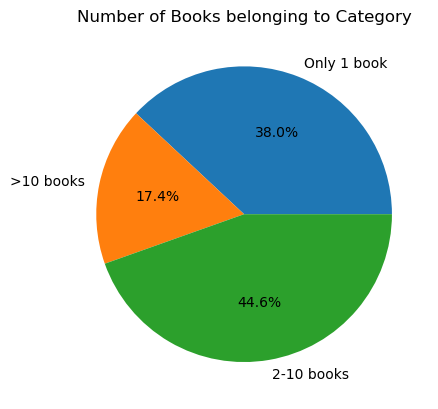

In [35]:
categ_ten_plus = len([category[0] for category in category_counts if category[1] > 10])
categ_one_book = len([category[0] for category in category_counts if category[1] == 1])
pie_categ_array = np.array([categ_one_book, categ_ten_plus, len(category_counts) - categ_ten_plus- categ_one_book])
pie_categ_labels = ["Only 1 book",">10 books", "2-10 books"]
plt.pie(pie_categ_array, labels = pie_categ_labels, autopct='%1.1f%%')
plt.title("Number of Books belonging to Category")
plt.show()

From the pie chart above, most categories have between 2 and 10 books attributed to them whereas more than a third of the categories are only attributed to a single book. 

## Limitations and Solutions

From the analysis above, a number of worst case scenarios were identified which need to be handled by the recommendation system:

1. All the books inputted to the user belong to a distinct category i.e. no common category between inputs.
2. All the books in the category are already read or too little books exist in the category.

To cater for the first scenario, the recommendation system must handle returning more than 1 common category and return the highest-rated, unread book in the category. Therefore, assuming scenario 1, the system would recommend the highest-rated book from each of the inputted titles' categories.

A solution for the second scenario would be to use NLP to find semantically similar categories and return the titles from those categories. A simpler alternative (albeit less accurate) could be to use fuzzy string matching with the 'fuzzywuzzy' Python package which computes the Levenshtein distance between text strings. 

While the former limitation will be catered for in this notebook, the latter is beyond the scope of this assignment and can be considered as a further improvement to the project.


## Expert System in CLIPS

The CLIPS implementation must be able to perform the following actions:
 1. Accept 10 book titles as an input.
 2. Infer the inputs' categories.
 3. Keep counts for every category encountered.
 4. Return the categories having the highest occurrence.
 
To achieve the above, a number of templates are defined which can guide us through each step. 

In [36]:
# Initiating the CLIPS environment and logger
env = Environment()

logger = LoggingRouter() 
logformat = '%(asctime)s - %(levelname)s - %(message)s'
logging.basicConfig(level=10, format=logformat)
env.add_router(logger)

# Defining the templates
book_template = """
(deftemplate book
  (slot title (type STRING))
  (slot author (type STRING))
  (slot category (type STRING))
)
"""

user_input_template = """
(deftemplate user-input
  (slot title (type STRING))
)
"""

input_match_template = """
(deftemplate input-match
  (slot title (type STRING))
  (slot category (type STRING))
)
"""

category_count_template = """
(deftemplate category-count
  (slot category (type STRING))
  (slot count (type INTEGER))
)
"""

# injecting the templates into clips
env.build(book_template)

env.build(user_input_template)

env.build(input_match_template)

env.build(category_count_template)

book_deftemplate = env.find_template('book')
input_deftemplate = env.find_template('user-input')

The next step is to initialise the knowledge base by looping over the books in the dataset and asserting them as 'book' template facts.

In [37]:
for index, book in df_books.iterrows():
    for book_category in book['categories']:
        try:
            book_deftemplate.assert_fact(title=book['title'], author=book['author'],category=book_category)
        except:
            print(f"Error when inserting [{book['title']}] into the knowledge base!")


env.eval("(run)")

After inserting each book, we define the rules. The rules are split into 2 categories:
1. Input Rules: these rules capture the user input and provide the most common category as a result.
2. Reset Rules: these rules reset the knowledge base to the book facts only, primed for another user input.

In [38]:
# INPUT RULES
## List the user inputs
rule_user_input = """
(defrule print-user-input
  "Prints the user input."
  (declare (salience 90))
  (user-input (title ?title))
  =>
  (println "User input: " ?title))
"""


env.build(rule_user_input)


## Match the title to the book and category
rule_match_title_to_category = """
(defrule match-title-category
  "Matches the input to the existing book fact"
  (declare (salience 90))
  (book (title ?title) (author ?author) (category ?category))
  (user-input (title ?title))
  =>
  (assert (input-match (title ?title) (category ?category)))
  (println "Matched book [" ?title "] to category [" ?category "]"))
"""

env.build(rule_match_title_to_category)

## Initiate count for the first input-match of the respective category
rule_count_new_category = """
(defrule count-new-category
  "Increment the count for a category which is newly already encountered"
  (declare (salience 90))
  ?b <- (input-match (title ?title) (category ?category))
  (not (category-count (category ?category)))
  =>
  (println "Found first book [" ?title "] for category [" ?category "]; Setting count to 1 ")
  (assert (category-count (category ?category) (count 1)))
  (retract ?b))
"""

env.build(rule_count_new_category)

## Increment count for a category which was previously encountered
rule_count_existing_category = """
(defrule count-existing-category
  "Increment the count for a category which was already encountered"
  (declare (salience 90))
  ?b <- (input-match (title ?title) (category ?category))
  ?c <- (category-count (category ?category) (count ?count1))
  =>
  (bind ?count2 (+ ?count1 1))
  (println "Found book [" ?title "] for category [" ?category "]; increasing count from  [" ?count1 "] to [" ?count2 "]")
  (modify ?c (count ?count2))
  (retract ?b))
"""

env.build(rule_count_existing_category)


## Compare category-counts and retract the one with the lower count
rule_drop_least_common = """
(defrule drop-least-common-category
(declare (salience 80))
?c1 <- (category-count (category ?category1) (count ?count1))
?c2 <- (category-count (category ?category2) (count ?count2)) (not (eq ?category1 ?category2))
(test (> ?count1 ?count2))
=>
(retract ?c2)
(println "Category [" ?category1 "] has more entries than [" ?category2 "]"))
"""

env.build(rule_drop_least_common)

# Report the most common categories
rule_report_most_common = """
(defrule report-most-common-category
(declare (salience 70))
(category-count (category ?category) (count ?count))
=>
(println "The most common category is [" ?category "] with a count of [" ?count "]"))
"""
env.build(rule_report_most_common)


# RESET RULES
## Reset user inputs
rule_reset_user_inputs = """
(defrule reset-user-inputs
(declare (salience 100))
(reset-all)
?i1 <- (user-input (title ?title))
=>
(retract ?i1))
"""

## Reset category counts
env.build(rule_reset_user_inputs)

rule_reset_category_counts = """
(defrule reset-category-counts
(declare (salience 100))
(reset-all)
?c1 <- (category-count)
=>
(retract ?c1))
"""

env.build(rule_reset_category_counts)

## Reset complete
rule_reset_reset_complete = """
(defrule reset-complete
(declare (salience 95))
?r1 <- (reset-all)
=>
(retract ?r1)
(println "Reset Complete"))
"""

env.build(rule_reset_reset_complete)



For the user input, we have 2 options:

1. Sampling 10 random titles from the dataset; OR
2. Inputting 10 titles manually.

Depending on the chosen input method, we can un/comment the below accordingly:

In [59]:
user_inputs = []

## USER INPUT OPTION 1 - 10 random titles

book_sample = df_books.sample(n=10)

for index, book in book_sample.iterrows():
    input_deftemplate.assert_fact(title=book['title'])
    user_inputs.append(book['title'])
    
#? USER INPUT OPTION 2 - 10 manually inputted titles

# user_inputs = ['1','2','3','4','5','6','7','8','9','10']
# for book_title in user_inputs:
#     input_deftemplate.assert_fact(title=book_title)
    

env.eval("(run)")
    

2023-02-27 22:52:40,859 - INFO - User input: The Water Dancer (Oprah's Book Club): A Novel
2023-02-27 22:52:40,860 - INFO - Matched book [The Water Dancer (Oprah's Book Club): A Novel] to category [United States]
2023-02-27 22:52:40,861 - INFO - Found first book [The Water Dancer (Oprah's Book Club): A Novel] for category [United States]; Setting count to 1 
2023-02-27 22:52:40,862 - INFO - Matched book [The Water Dancer (Oprah's Book Club): A Novel] to category [Black & African American]
2023-02-27 22:52:40,863 - INFO - Found first book [The Water Dancer (Oprah's Book Club): A Novel] for category [Black & African American]; Setting count to 1 
2023-02-27 22:52:40,865 - INFO - Matched book [The Water Dancer (Oprah's Book Club): A Novel] to category [Literature & Fiction]
2023-02-27 22:52:40,866 - INFO - Found first book [The Water Dancer (Oprah's Book Club): A Novel] for category [Literature & Fiction]; Setting count to 1 
2023-02-27 22:52:40,867 - INFO - Matched book [The Water Dancer

After the inputs and rules are evaluated, we can loop over the remaining 'category-count' facts which are the most frequently occuring categories from the inputs provided.

In [40]:
common_categories = []

for fact in env.facts():
    if fact.template.name == 'category-count':
        print(fact['category'])
        common_categories.append(fact['category'])

Mystery, Thriller & Suspense
Thrillers & Suspense


Before providing a new input to the system, the system must be reset to clear 'input-matches' and 'category-counts' which would otherwise affect the new input. 

In [58]:
# Reset knowledge base to initial state i.e. only book facts

env.eval("""
(assert (reset-all))
""")

env.eval("(run)")

2023-02-27 22:52:40,991 - INFO - Reset Complete


## Getting Recommendations

The output of the expert system is a list of categories from which recommendations must be made.

In [42]:
common_categories

['Mystery, Thriller & Suspense', 'Thrillers & Suspense']

Given that multiple categories may be recommended, we can employ a simple 'round-robin' system to increment the counts for each category until a total count of 10 is reached. This will determine the split for the top 10 recommendations.

In [43]:
# split the recommendations using a round-robin strategy i.e. add a count for each until the maximum is reached

max_recommendations = 10
categ_count = dict.fromkeys(common_categories,0)

counter = 0
while counter < max_recommendations:
    for key,value in categ_count.items():
        if counter == max_recommendations: break
        categ_count[key] += 1
        counter += 1
        
categ_count



{'Mystery, Thriller & Suspense': 5, 'Thrillers & Suspense': 5}

The last step is to get the recommendations from the dataset. To return the recommendations, we define a function which performs the following logic:

  1. Remove the user inputs from the available books
  2. For each category, sort the books dataset by the rating and reviews in descending order and get the top 20 books.
  3. If the book is not in the recommendations list, add it to the list. Otherwise, skip it.
  4. Repeat the above until enough books for that category are in the recommendations list.
  5. Print out the full list of recommendations.

In [76]:
def get_recommendations(user_inputs, category_count):
    recommendations = {}
    
    df_books2 = df_books[~df_books.title.isin(user_inputs)] # exclude user inputs from dataframe
    
    for categ, max_count in category_count.items():
        # get top 10 for each category
        df_books3 = df_books2[df_books2['categories'].str.contains(categ, regex=False)].sort_values(by=['rating','reviews_count'],ascending=[False,False])[:20]
        current_count = 0
        for index, book in df_books3.iterrows():
            if book['title'] in recommendations:
                pass
            else:
                recommendations[book['title']] = book['author']
                current_count += 1
            if current_count >= max_count: break
            
    print("Your recommended readings are:")
    for idx,(title,author) in enumerate(recommendations.items()):
        print(f"{idx+1}. {title} by {author}")


In [75]:
get_recommendations(user_inputs, categ_count)

1. Battle Ground (Dresden Files) by Jim Butcher
2. Shadows in Death: An Eve Dallas Novel: In Death, Book 51 by Susan Ericksen (Narrator), J. D. Robb (Author), Macmillan Audio (Publisher) & 0 more
3. Faithless in Death: An Eve Dallas Novel (In Death, 52) by J. D. Robb
4. Forgotten in Death: An Eve Dallas Novel by J. D. Robb
5. Forgotten in Death: An Eve Dallas Novel (In Death, 53) by J. D. Robb
6. Project Hail Mary: A Novel by Andy Weir
7. The Institute: A Novel by Stephen King
8. Ocean Prey by John Sandford (Author), Richard Ferrone (Narrator), Penguin Audio (Publisher) & 0 more
9. Doctor Sleep by Stephen King
10. It: A Novel by Stephen King


## Conclusions and Future Improvement

By including an expert system encoded in the CLIPS, a simple albeit performant recommendation system was successfully developed based on the provided dataset. Although the desired output was attained, a number of limitations are apparent:

- The dataset is unbalanced, favoring certain genres e.g. Literature & Fiction
- Similar entries which are not exact duplicates were not completely removed 

Despite the shortcomings of this implementation, it was an interesting introduction to application of expert systems and their role in Artificial Intelligence.